In [1]:
using CUDAdrv; CUDAdrv.name(CuDevice(0))

"GeForce MX150"

In [7]:
using CuArrays, FileIO, Colors, GPUArrays, BenchmarkTools, ImageShow

┌ Info: Precompiling ImageShow [4e3cecfd-b093-5904-9786-8bbb286a6a31]
└ @ Base loading.jl:1260


In [8]:
using CuArrays: CuArray

In [9]:
"""
The function calculating the Julia set
"""
function juliaset(z0, maxiter)
    c = ComplexF32(-0.5, 0.75)
    z = z0
    for i in 1:maxiter
        abs2(z) > 4f0 && return (i - 1) % UInt8
        z = z * z + c
    end
    return maxiter % UInt8 # % is used to convert without overflow check
end

juliaset

In [10]:
range = 100:50:2^12
cutimes, jltimes = Float64[], Float64[]

(Float64[], Float64[])

In [11]:
function run_bench(in, out)
  # use dot syntax to apply `juliaset` to each elemt of q_converted 
  # and write the output to result
  out .= juliaset.(in, 16)
  # all calls to the GPU are scheduled asynchronous, 
  # so we need to synchronize
  GPUArrays.synchronize(out)
end

run_bench (generic function with 1 method)

In [12]:
# store a reference to the last results for plotting
last_jl, last_cu = nothing, nothing
for N in range
  w, h = N, N
  q = [ComplexF32(r, i) for i=1:-(2.0/w):-1, r=-1.5:(3.0/h):1.5]
  for (times, Typ) in ((cutimes, CuArray), (jltimes, Array))
    # convert to Array or CuArray - moving the calculation to CPU/GPU
    q_converted = Typ(q)
    result = Typ(zeros(UInt8, size(q)))
    for i in 1:10 # 5 samples per size
      # benchmarking macro, all variables need to be prefixed with $
      t = Base.@elapsed begin
				run_bench(q_converted, result)
      end
      global last_jl, last_cu # we're in local scope
      if result isa CuArray
        last_cu = result
      else
      	last_jl = result
      end
      push!(times, t)
    end
  end
end

┌ Info: Precompiling ImageIO [82e4d734-157c-48bb-816b-45c225c6df19]
└ @ Base loading.jl:1260
┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1260
┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1260


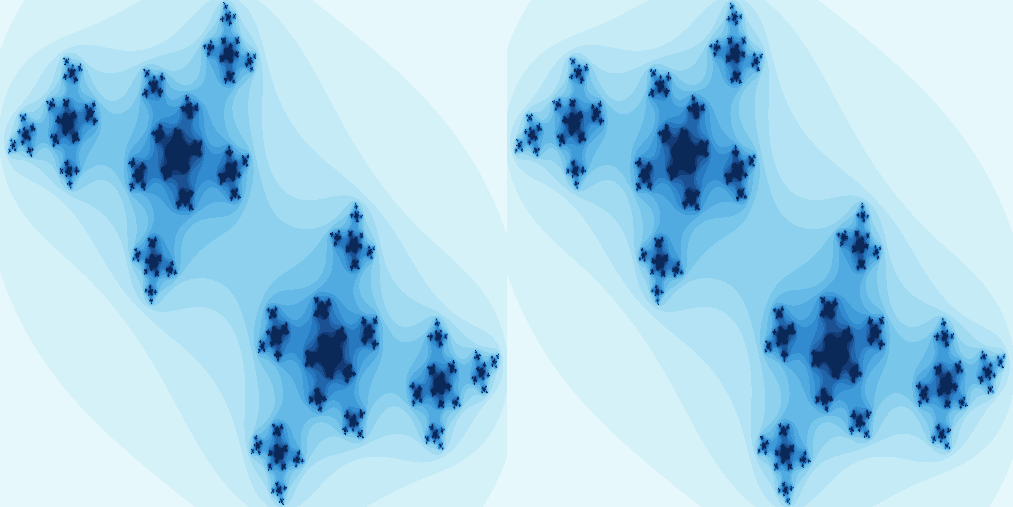

In [14]:
cu_jl = hcat(Array(last_cu), last_jl)
cmap = colormap("Blues", 16 + 1)
color_lookup(val, cmap) = cmap[val + 1]
color_lookup.(cu_jl, (cmap,))

In [18]:
using Plots; plotly()
x = repeat(range, inner = 10)
speedup = jltimes ./ cutimes
Plots.scatter(
  log2.(x), [speedup, fill(1.0, length(speedup))], 
  label = ["cuda" "cpu"], markersize = 2, markerstrokewidth = 0,
  legend = :right, xlabel = "2^N", ylabel = "speedup"
)

<!DOCTYPE html>
 
 
 Plots.jl

As you can see, for large arrays one gets a solid 50-80x speed-up by moving the calculation to the GPU. Getting this speed-up was as simple as converting the Julia array to a GPUArray.

One might think that the GPU performance suffers from being written in a dynamic language like Julia, but Julia's GPU performance should be pretty much on par with the raw performance of CUDA or OpenCL. Tim Besard did a great job at integrating the LLVM Nvidia compilation pipeline to achieve the same – or sometimes even better – performance as pure CUDA C code. Tim published a pretty detailed blog post in which he explains this further. CLArrays approach is a bit different and generates OpenCL C code directly from Julia, which has the same performance as OpenCL C!

To get a better idea of the performance and see some comparisons to multi-threadded CPU code, I collected some more benchmarks.

In [19]:
struct Test # an immutable struct
# that only contains other immutable, which makes 
# isbitstype(Test) == true
	x::Float32 
end

# the isbits property is important, since those types can be used
# without constraints on the GPU!
@assert isbitstype(Test) == true
x = (2, 2)
isa(x, Tuple{Int, Int}) # tuples are also immutable
mutable struct Test2 #-> mutable, isbits(Test2) == false
	x::Float32
end
struct Test3
	# contains a heap allocation/ reference, not isbits
	x::Vector{Float32}
	y::Test2 # Test2 is mutable and also heap allocated / a reference
end
Vector{Test} # <-  An Array with isbits elements is contigious in memory
Vector{Test2} # <- An Array with mutable elements is basically an array of heap pointers. Since it just contains cpu heap pointers, it won't work on the GPU.

Array{Test2,1}

**The GPU Array Constructors**

In [21]:
using CuArrays, LinearAlgebra
using CuArrays.CURAND

# GPU Arrays can be constructed from all Julia arrays containing isbits types!
A1D = cu([1, 2, 3]) # cl for CLArrays
A1D = CuArrays.fill(0, 100) # CLArray for CLArrays
# Float32 array - Float32 is usually preferred and can be up to 30x faster on most GPUs than Float64
diagonal_matrix = CuArray{Float32}(I, 100, 100)
filled = CuArrays.fill(77f0, (4, 4, 4)) # 3D array filled with Float32 77
randy = CuArrays.rand(42, 42) # random numbers generated on the GPU
# The array constructor also accepts isbits iterators with a known size
# Note, that since you can also pass isbits types to a gpu kernel directly, in most cases you won't need to materialize them as an gpu array
from_iter = CuArray(1:10)
# let's create a point type to further illustrate what can be done:
struct Point
    x::Float32
    y::Float32
end
Base.convert(::Type{Point}, x::NTuple{2, Any}) = Point(x[1], x[2])
# because we defined the above convert from a tuple to a point
# [Point(2, 2)] can be written as Point[(2,2)] since all array 
# elements will get converted to Point
custom_types = cu(Point[(1, 2), (4, 3), (2, 2)])
typeof(custom_types)

CuArray{Point,1,Nothing}

**Array Operations**

In [22]:
x = zeros(4, 4) # 4x4 array of zeros
y = zeros(4) # 4 element array
z = 2 # a scalar
# y's 1st dimension gets repeated for the 2nd dimension in x
# and the scalar z get's repeated for all dimensions
# the below is equal to `broadcast(+, broadcast(+, xx, y), z)`
x .+ y .+ z

4×4 Array{Float64,2}:
 2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0

This means any Julia function that runs without allocating heap memory (only creating isbits types), can be applied to each element of a GPUArray and multiple dot calls will get fused into one kernel call. As kernel call latency is high, this fusion is a very important optimization.

In [24]:
using CuArrays
A = cu([1, 2, 3])
B = cu([1, 2, 3])
C = CuArrays.rand(3)
result = A .+ B .- C
test(a::T) where T = a * convert(T, 2) # convert to same type as `a`

# inplace broadcast, writes directly into `result`
result .= test.(A) # custom function work

# The cool thing is that this composes well with custom types and custom functions.
# Let's go back to our Point type and define addition for it
Base.:(+)(p1::Point, p2::Point) = Point(p1.x + p2.x, p1.y + p2.y)

# now this works:
custom_types = cu(Point[(1, 2), (4, 3), (2, 2)])

# This particular example also shows the power of broadcasting: 
# Non array types are broadcasted and repeated for the whole length
result = custom_types .+ Ref(Point(2, 2))

# So the above is equal to (minus all the allocations):
# this allocates a new array on the gpu, which we can avoid with the above broadcast
broadcasted = fill(CuArray, Point(2, 2), (3,))

result == custom_types .+ broadcasted

true